In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_tweets(tweets_attributes_file, tweets_text_file):
    df = pd.read_csv(tweets_attributes_file, index_col=0)
    text = []
    with open(tweets_text_file, 'r') as f:
        for line in f:
            text.append(line)
    df['text'] = text
    return df

In [3]:
# Load tweet data
tweets_attributes_file = 'sandy_tweets_attributes_rev_geocoded_formatted_timestamps.csv'
tweets_text_file = 'sandy_tweets_text_tokenized.txt'

df = load_tweets(tweets_attributes_file, tweets_text_file)
#df = pd.read_csv(open('sandy_tweets_1.csv'), encoding='utf-8', engine='c')
df.head()

,tweet_id,user_id,retweet_count,time_stamp,longitude,latitude,state,county,county_tweet_count,sentiment,text
0,260244125050363904,295902181,0,2012-10-22 05:00:09,-74.078101,40.735218,New Jersey,Hudson County,52264,1,all i wish is to be better than yesterday and ...
1,260244177412042752,85314436,0,2012-10-22 05:00:21,-81.505790,33.460462,South Carolina,Barnwell County,1375,0,@imSunnyAF yesssss lawd\n
2,260244177105850368,239968255,0,2012-10-22 05:00:21,-77.099999,39.344184,Maryland,Carroll County,7707,1,"""Waiting for something better , a better you ...."
3,260244156729942016,703352862,0,2012-10-22 05:00:17,-80.907470,39.618102,West Virginia,Tyler County,175,1,Cool right ? #plainoldshirt http://t.co/B55dMS...
4,260244145694728192,581488152,0,2012-10-22 05:00:14,-76.579826,39.816450,Pennsylvania,York County,20191,0,#10PeopleYouTrulyLove My son\n


In [4]:
# Replace missing value in 'county' column by empty string. e.g. Washington D.C.
df['county'] = df['county'].replace(np.nan,'', regex=True)

# Convert to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [5]:
print (min(df['time_stamp']))
print (max(df['time_stamp']))

2012-10-22 05:00:00
2012-11-02 04:59:51


In [6]:
import pytz

def plot_tweets_per_hour(df):
    # Set datetime as index
    df1 = df.set_index(['time_stamp'])
    # Group tweets by hour
    #tweets_per_hr = df1['tweet_id'].resample('H', how='count')
    tweets_per_hr = df1['tweet_id'].resample('H').count()
    
    eastern = pytz.timezone('US/Eastern')
    tweets_per_hr.index = tweets_per_hr.index.tz_localize(pytz.utc).tz_convert(eastern)
    
    plt.plot(tweets_per_hr.index, tweets_per_hr, 'r')
    plt.ylabel('Tweets per hour')
    plt.xticks(rotation='vertical')
    plt.show()

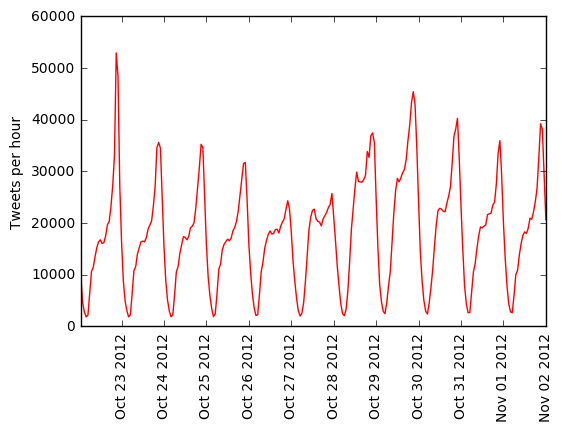

In [7]:
plot_tweets_per_hour(df)

## Filter Sandy related tweets and plot count as a function of time

In [8]:
sandy_keywords = ['sandy', 'hurricane', 'hurricanesandy', 'storm', 'frankenstorm']
sandy_keywords = sandy_keywords + ['#'+kw for kw in sandy_keywords]

pattern = ' ' + ' | '.join(sandy_keywords) + ' '
pattern
df_sandy = df[df['text'].str.contains(pattern)]

In [9]:
print ('Total number of Sandy related tweets: %d' % len(df_sandy))

Total number of Sandy related tweets: 54105


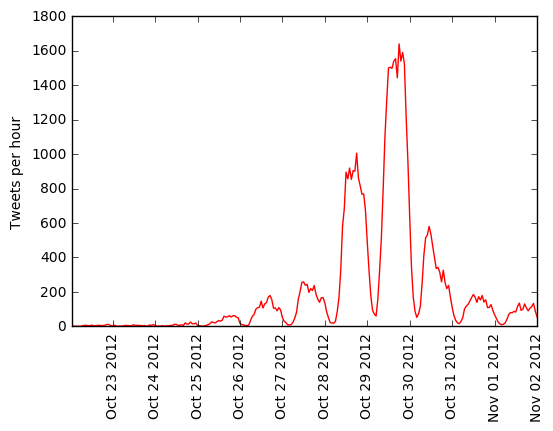

In [10]:
plot_tweets_per_hour(df_sandy)

In [11]:
from bokeh.io import output_notebook, show
output_notebook()

from bokeh.plotting import figure, ColumnDataSource
from bokeh.tile_providers import WMTSTileSource
from bokeh.plotting import Figure, show, output_file
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import LinearAxis, Range1d

from bokeh.models.formatters import DatetimeTickFormatter

import matplotlib.cm as cm
from math import pi

Loading BokehJS ...

In [12]:
import pytz

def prep_plot(df):
    # Group tweets by hour
    df2 = df.set_index(['time_stamp'])
    tweets_per_hr = df2['tweet_id'].resample('H').count()

    eastern = pytz.timezone('US/Eastern')
    tweets_per_hr.index = tweets_per_hr.index.tz_localize(pytz.utc).tz_convert(eastern)
    x = pd.DataFrame(tweets_per_hr.index )
    x = pd.to_datetime(x['time_stamp'])
    y = list(tweets_per_hr.values)
    
    return x, y

In [ ]:
x1, y1 = prep_plot(df)
x2, y2 = prep_plot(df_sandy)

output_file('tweet_traffic_vs_time.html')

p = figure(plot_width=800, plot_height=400, x_axis_type="datetime", toolbar_location="above")

# Setting the second y axis range name and range
p.extra_y_ranges = {"sandy": Range1d(start=0, end=2000)}
# Adding the second axis to the plot.  
p.add_layout(LinearAxis(y_range_name="sandy"), 'right')

## add lines
#p.line([1, 2, 3, 4, 5], [6, 7, 6, 4, 5], line_width=2)
#p.line(x=[1, 2, 3, 4, 5], y=[1, 4, 2, 5, 3], line_width=4, color="#CAB2D6", y_range_name="foo")

p.line(x1, y1, color='navy', alpha=0.5, line_width=2, legend="All Tweets")
p.line(x2, y2, color='red', alpha=1, line_width=2, y_range_name="sandy", legend="Sandy related Tweets")

# Setting the y  axis range   
#p.y_range = Range1d(0, 12)    

p.axis.major_label_text_font_size = "10pt"
p.yaxis.axis_label = 'Tweets per hour'
p.yaxis[0].axis_line_color = "navy"
p.yaxis[1].axis_line_color = "red"
p.xgrid[0].ticker.desired_num_ticks = 12 # 12 days

p.xaxis.formatter = DatetimeTickFormatter(days = ['%b %d'])
p.xaxis.major_label_orientation = pi / 3


#p.ylabel('Tweets per hour')
#p.xticks(rotation='vertical')
show(p)